Краткое описание проекта: музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача: правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. В датасете собраны некоторые характеристики музыкальных произведений и их жанры. Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Загрузка необходимых для работы библиотек:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
import warnings
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import phik
from sklearn.decomposition import PCA
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

Загружаем тренировоный и тестовый датасеты.

In [2]:
data = pd.read_csv('kaggle_music_genre_train.csv')
df_test = pd.read_csv('kaggle_music_genre_test.csv')

Пропуски есть в столцбах key, mode, tempo как в тренировочном, так и в тестовом датасетах. Категориальные признаки: track_name, key, mode, obtained_date.

In [3]:
print(data.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Признак instance_id смысловой нагрузки не несет, поэтому удалим его, также сделаем и с track_name 

In [4]:
data = data.drop('instance_id' , axis = 1)
df_id = df_test['instance_id']
df_test = df_test.drop('instance_id', axis = 1)

In [5]:
data = data.drop('track_name' , axis = 1)
df_test = df_test.drop('track_name', axis = 1)

Преобразуем признак obtained_date в числовой признак

In [6]:
data['obtained_date'] = data['obtained_date'].str[:1].astype('int')
df_test['obtained_date'] = df_test['obtained_date'].str[:1].astype('int')

Исследуем числовые признаки тренировочного набора данных на наличие выбросов и аномальных значений.

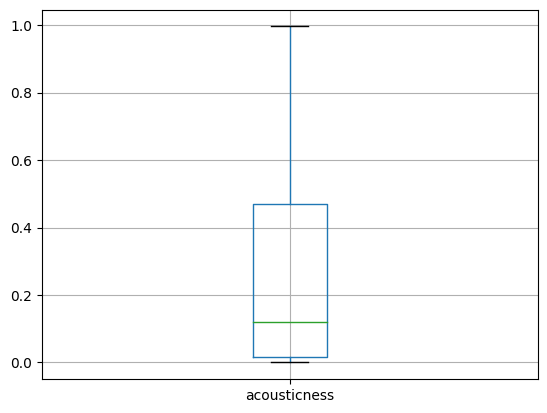

In [7]:
data.boxplot(column = 'acousticness')
plt.show()

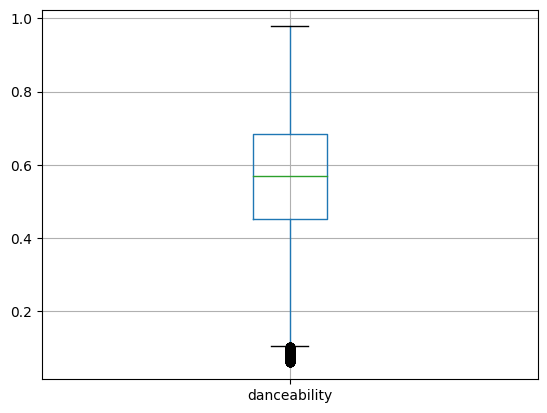

In [8]:
data.boxplot(column = 'danceability')
plt.show()

Очевидно, что длительность песни, превышающая 25 минут - аномалия.

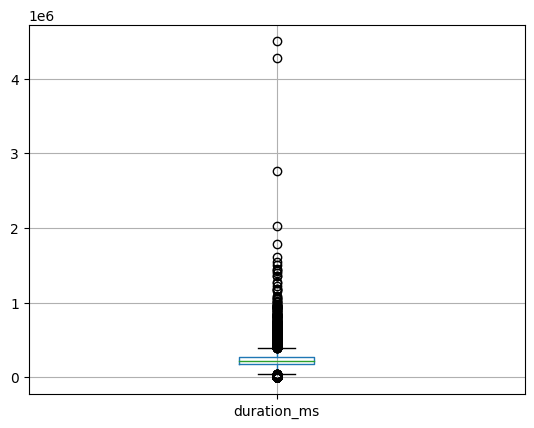

8


In [9]:
data.boxplot(column = 'duration_ms')
plt.show()
print(data[data['duration_ms']>1.5*(10**6)]['duration_ms'].count())

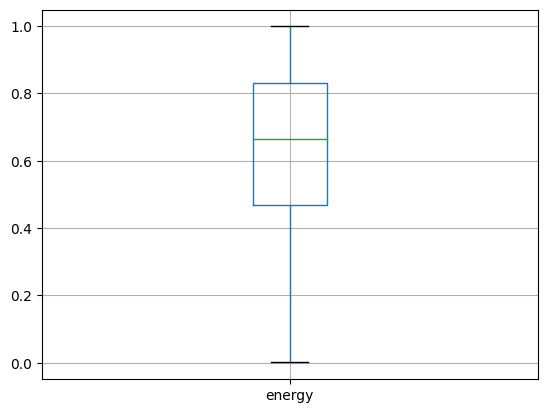

In [10]:
data.boxplot(column = 'energy')
plt.show()

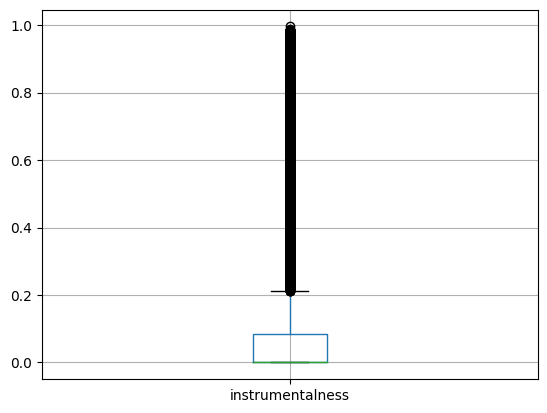

In [11]:
data.boxplot(column = 'instrumentalness')
plt.show()

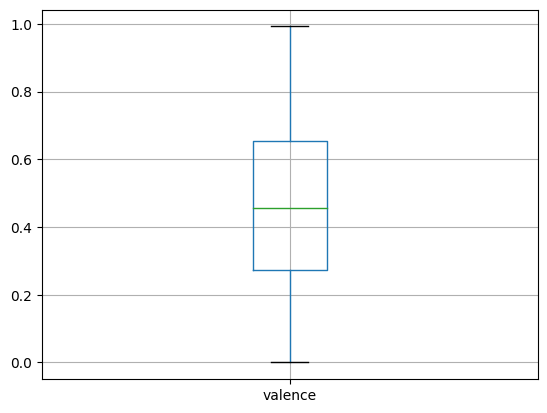

In [12]:
data.boxplot(column = 'valence')
plt.show()

Удалим значения в столбце tempo > 205, их всего 37, можно это себе позволить, несмотря на небольшой тренировочный датасет.

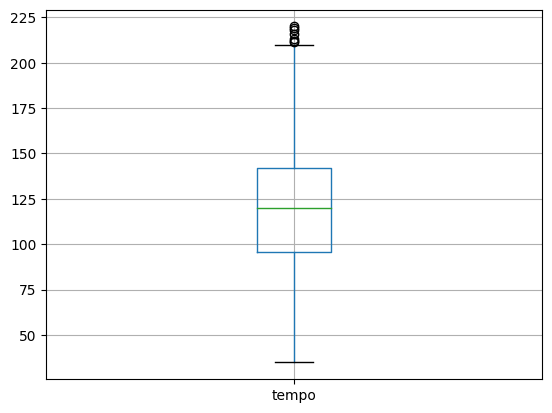

37

In [13]:
data.boxplot(column = 'tempo')
plt.show()
data[data['tempo']>205]['tempo'].count()

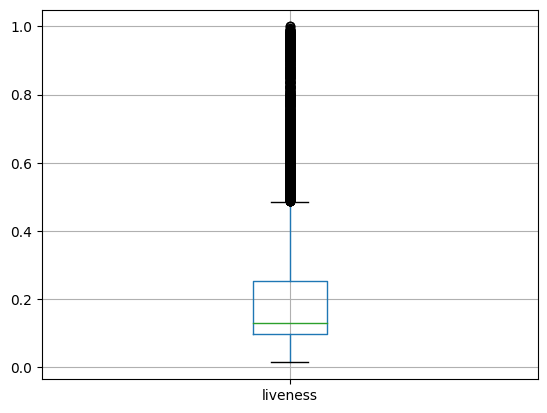

In [14]:
data.boxplot(column = 'liveness')
plt.show()

Очевидно, что значения в столбце loudness должны быть положительными

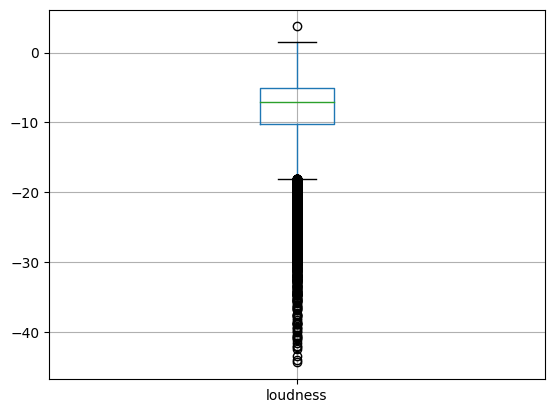

In [15]:
data.boxplot(column = 'loudness')
plt.show()

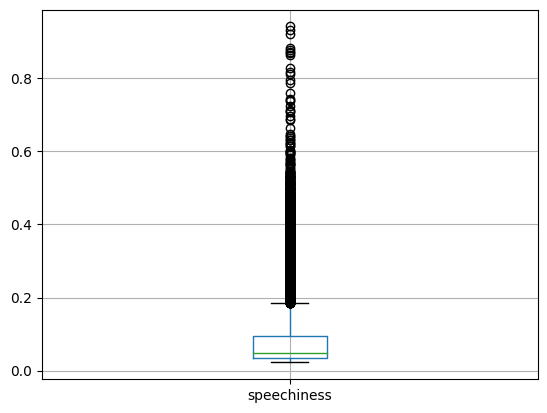

In [16]:
data.boxplot(column = 'speechiness')
plt.show()

На основе обнаруженных выше аномалиях, напишем три функции для обработки данных в столбцах tempo, durations_ms, loudness. Все аномальные значения и выбросы заполним медианой.

In [17]:
def tempo(df):
    df['tempo'] = df['tempo'].fillna(df['tempo'].mean())
    for i in data[data['tempo']>205]['tempo'].index:
        df['tempo'][i] = df['tempo'].mean()
    return df
def duration_ms(df):
    df['duration_ms'] = df['duration_ms'].fillna(df['duration_ms'].mean())
    for i in data[data['duration_ms']<60000]['duration_ms'].index:
        df['duration_ms'][i] = df['duration_ms'].mean()
    for i in data[data['duration_ms']>1.5*(10**6)]['duration_ms'].index:
        df['duration_ms'][i] = df['duration_ms'].mean()
    return df
def loudness(df):
    df['loudness'] = df['loudness'].fillna(df['loudness'].mean())
    df['loudness'] = abs(df['loudness'])
    return df

Тк mode == major встречается встречается в 1.8 раза чаще, чем minor, заполним пропуски в столбце mode значением Major.

In [18]:
data.groupby(by = 'mode')['music_genre'].count()

mode
Major    12828
Minor     7060
Name: music_genre, dtype: int64

In [19]:
data['mode'] = data['mode'].fillna('Major')


Применим описанные выше функции к тренировочным данным

In [21]:
warnings.filterwarnings('ignore')
data = tempo(data)
data = duration_ms(data)
data = loudness(data)
df_test['key'] = df_test['key'].fillna(1)
df_test['mode'] = df_test['mode'].fillna('Major')
df_test = tempo(df_test)
df_test = duration_ms(df_test)
df_test = loudness(df_test)

Так как наиболее часто встречаются классы d и b, заполнить все пропуски одним из них не получится, поэтому оставшиеся пропуски просто удалим.

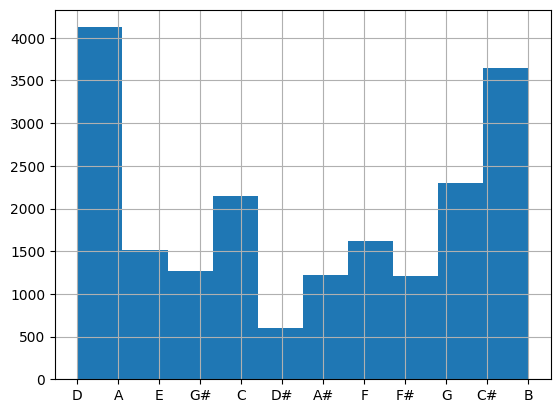

In [22]:
data['key'].hist()
plt.show()

In [23]:
data = data.dropna()

Целевой признак сбалансирован

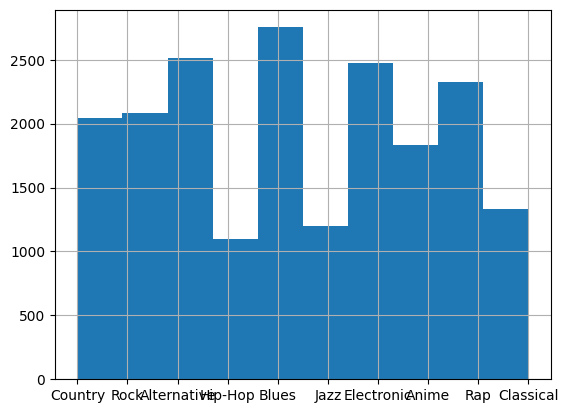

In [24]:
data['music_genre'].hist()
plt.show()

Посмотрим на то, как признаки коррелируют друг с другом

phik_overview = data.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

Сильно друг с другом коррелируют energy  и loudness, что впрочем логично. 
Удаление одного из них ухудшает метрику модели.

Обрабатываем данные для логистической регрессии

In [25]:
df_log = data.copy()
df_test_log = df_test.copy()

Отделим целевой признак

In [26]:
X = df_log.drop('music_genre', axis = 1)
Y = df_log['music_genre']

In [27]:
num_columns = X.select_dtypes(include='number').columns.tolist()
cat_columns = X.select_dtypes(exclude='number').columns.tolist()

In [28]:
column_transformer = make_column_transformer((MinMaxScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  
model = LogisticRegression(random_state=42)
log = make_pipeline(column_transformer, model)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 12345, stratify=Y)

In [30]:
warnings.filterwarnings('ignore')
params = {
          'logisticregression__max_iter': range(600,1001,100),
          'logisticregression__n_jobs': range(1, 4, 1)
         }
         

grid = GridSearchCV(log, params, cv=5, scoring='f1_micro')
grid.fit(x_train, y_train, )

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'obtained_date',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__max_iter': range(600, 1001, 100),
                         'logisticregression__n_jobs': range(1, 4)},
             scoring='f1_micro')

In [31]:
print(grid.best_score_, grid.best_params_)

0.40408264664949156 {'logisticregression__max_iter': 600, 'logisticregression__n_jobs': 1}


При помощи логистической регрессии удалось достичь метрики 0.4 на кроссвалидации.

Построение модели случайного леса

In [32]:
X = data.drop('music_genre', axis=1)  
y = data['music_genre'] 

In [33]:
num_columns = X.select_dtypes(include='number').columns.tolist()
cat_columns = X.select_dtypes(exclude='number').columns.tolist()

In [34]:
column_transformer = make_column_transformer((MinMaxScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')  
model = RandomForestClassifier(criterion = 'gini', random_state = 44)
pipeline = make_pipeline(column_transformer, model)


In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 12345, stratify=Y)

In [36]:
from sklearn.preprocessing import MinMaxScaler

params = {
          'randomforestclassifier__n_estimators': range(60,101,10),
          'randomforestclassifier__max_depth': range(1, 13, 3),
          'randomforestclassifier__min_samples_split': range (6,13,2) 
         }
         

grid = GridSearchCV(pipeline, params, cv=5, scoring='f1_micro')
grid.fit(x_train, y_train, )

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'obtained_date',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=44))]),
             param_grid={'randomforestclassifier__max_depth': range(1, 13, 3),
                         'randomforestclassifier__min_samples_split': range(6, 13, 2),
                         'randomforestclassifier__n_estimators': range(60, 101, 10)},
             scoring='f1_micro')

In [37]:
print(grid.best_score_,grid.best_params_)

0.4654416287571368 {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 80}


При помощи модели случайного леса удалось достичь метрики 0.465, что заметно лучше логистической регрессии

Создание модели catboost

In [38]:
X = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'obtained_date']

cat_features = ['key', 'mode']

Y = ['music_genre']

Переводим данные в формат Pool

In [39]:
data_train = Pool(data = data[X],
                  label = data[Y],
                  cat_features = cat_features)
data_test = Pool(data = df_test[X],
                  cat_features = cat_features)
                                    

Параметры для кроссвалидации

In [46]:
params = {'cat_features': cat_features,
          'eval_metric': 'TotalF1',
          'loss_function': 'MultiClass',
          'learning_rate': 0.05,
          'iterations' : 1000,
          'depth': 7,
          'random_seed': 44,
          'verbose':100}

Проводим кроссвалидацию, настраивая гиперпараметры (с помощью изменения learning_rate приближаем модель к 1000 итераций на лучшей метрике)

In [47]:
cv_data = cv(
    params = params,
    pool = data_train,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    stratified = True,
    verbose = False,
    early_stopping_rounds = 100)

Training on fold [0/5]

bestTest = 0.4519103543
bestIteration = 639

Training on fold [1/5]

bestTest = 0.4654404891
bestIteration = 421

Training on fold [2/5]

bestTest = 0.4635606998
bestIteration = 716

Training on fold [3/5]

bestTest = 0.4590571183
bestIteration = 428

Training on fold [4/5]

bestTest = 0.4483162728
bestIteration = 264



In [48]:
cv_data[cv_data['test-TotalF1-mean'] == cv_data['test-TotalF1-mean'].max()]

,iterations,test-TotalF1-mean,test-TotalF1-std,train-TotalF1-mean,train-TotalF1-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
716,716,0.455214,0.008561,0.629004,0.047165,1.39847,0.024275,1.05499,0.083115


лучший результат, который удалось достичь на валидационной выборке при помощи модели catboost = 0.458, что хуже метрики случайного леса.

In [49]:
model = CatBoostClassifier(iterations = 1000, depth = 5,loss_function='MultiClass', verbose = False)
model.fit(data_train)
predictions = model.predict(data_test)


In [ ]:
predictions = pd.DataFrame(predictions)
df_id = pd.DataFrame(df_id)
df_id['predictions'] = predictions
df_id.columns = ['instance_id', 'music_genre']
df_id = pd.DataFrame(df_id)
df_id.to_csv('predictions_19', index = False)

Итоги проделанной работы: 
1) проведена предобработка данных (обработаны выбросы в данных, преобразованы типы данных, также проведена анализ мультиколлинеарности признаков)
2) Написаны 3 модели: случаный лес, логистическая регрессия, catboost
Лучшую метрику на валидационной выборке показал случайный лес, но у модели catboost метрика на тестовых данных значительно выше: 0.505